These are my the solutions to assignment 2. I have decided to write this document in a Jupyter notebook, since this allows me to report in the most natural and reproducible way on my results. 

We start by preparing the playground for this report and import some packages and detect if there is a CUDA device in the machine.

In [1]:
import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import Code


# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


I have written some helper functions in external `.py` files which perform various tasks such as data loading (`data_handling.py`), implementing a neural network abstraction class (`my_nn_pytorch.py`) and plotting performance measure (`my_plot_functions.py`). We load them here:

In [2]:
import data_handling as dh
import my_nn_pytorch as mnn
import my_plot_functions as mpf

This assignment is split into two parts: in section 1 we construct a convolutional neural network for the MNIST dataset while, in section 2, we build a convolutional neural network for biomedical image segmentation.

# Classification of hand-written digits using a Convolutional Neural Network

In this part of the assignment we construct a convolutional neural network for the MNIST dataset. The MNIST dataset is a commonly used benchmark dataset in machine learning, particularly for image classification tasks. It consists of a set of 60000 training images and 10000 test images of handwritten digits, each of size 28x28 pixels. The digits are grayscale images, and each image is labeled with the corresponding digit (0-9).

As a first step we therefore load the MNIST dataset. We have written a customised version of the `Dataset()` class in `pytorch` for the MNIST dataset. The `init_MNIST()` function loads the dataset using the custom class and returns two instances of `torch.utils.data.Dataloader()`, one for the training data and one for the test data:

In [3]:
batch_size_train = 64         # batch size during training
batch_size_test = 1000        # batch size for the test data
lr_sgd = 1e-1                 # learning rate for Stochastic Gradient Descent (SGD)
nepochs = 10                  # number of epochs to run the training

In [4]:
dataloader_train, dataloader_test = dh.init_MNIST(batch_size_train, batch_size_test)

Dataset MNISTDataset
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNISTDataset
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
Shape of X for train data [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y for train data:  torch.Size([64]) torch.int64
Shape of X for test data [N, C, H, W]:  torch.Size([1000, 1, 28, 28])
Shape of y for test data:  torch.Size([1000]) torch.int64


Next we define the hyper parameters, which we are going to use in the following. The rational behind the choice of the parameters is the following:
1. `batch_size_train`: we choose it small to avoid overfitting of the data even if it is computationally less efficient
2. `batch_size_test`: we choose it large, since my GPU can handle it and I think that the evaluation should go faster if we run it all at once
3. `lr_sgd`: I have observed that with this learning rate the training goes relatively fast and gives still good final accuracy
4. `nepochs`: After this number of epochs, the training did not improve the results much further.

Now the stage is set and we are ready to start buidling our neural networks.

## Fully connected neural network

As a first investigation, we establish a baseline by constructing a fully connected neural network with 4 fully connected layers. The network definition reads as follows:

In [5]:
class FullyConnectedMNIST(nn.Module):
    def __init__(self):
        super(FullyConnectedMNIST, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Now we train the network and after the training has commenced, we save the network in a pickle file to disk, so we can run the notebook again without redoing the training. We train the model in the following way:
- loss function: cross entropy loss for classification. The `pytorch` implementation of this function expects raw logits as input (the output of the last fully connected layer without applying a softmax to get class probabilities). The reason is that combining the softmax function and computing the cross entropy loss, as it is done in `CrossEntropyLoss()`, is numerically more stable.
- optimizer: we use plain standard stochastic gradient descent

In [6]:
fname = 'ex11_fc_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = FullyConnectedMNIST()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

We consider now the performance which this fully connected network achieves. By performance we mean here the prediction accuracy and the value of the loss. The figure below shows both performance figures as a function of epoch for the total training data set (blue color) and for the test data (orange color). Additionally the grey data points indicate the performance on the corresponding batch during the training. The accuracy does not improve meaningfully on the test data after 5 epochs, whereas the accuracy on the training data improves all the way up to 10 epochs. A similar observation can be made for the value of the loss. This suggests that after 5 epochs the model starts to be overfitted to the training data and we should probably terminate after 5 epochs if we were to use this model for any real purpose. The accuracy on the test data does not seem to be impacted much by the overfitting, however.

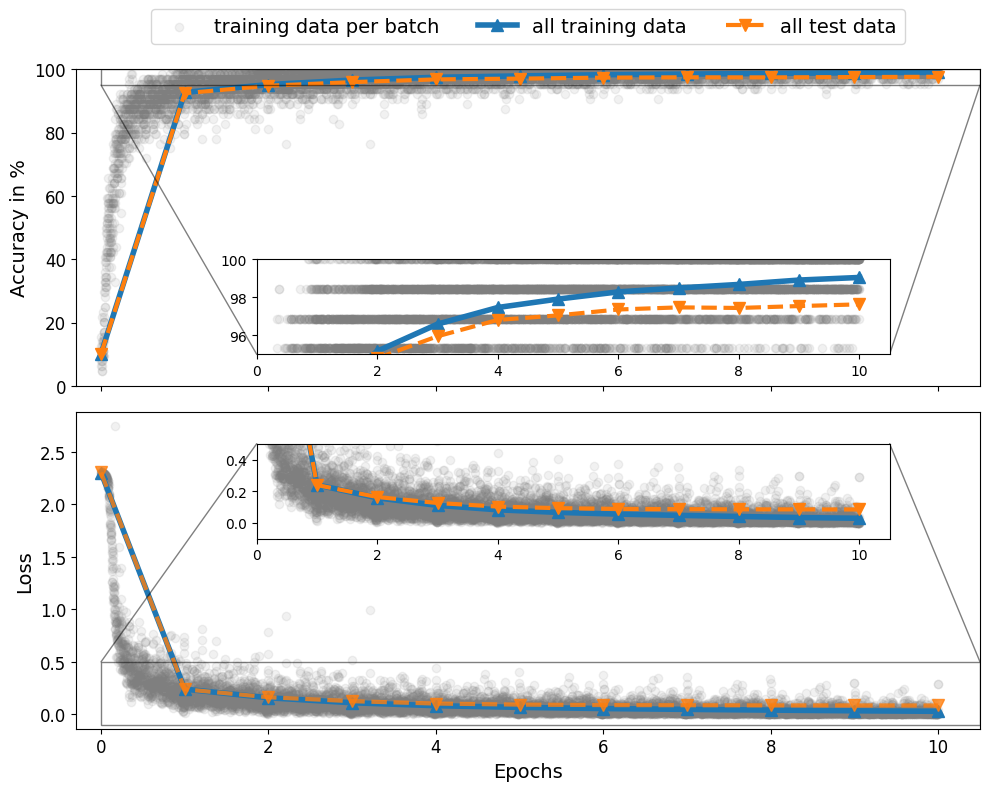

In [7]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

The final performance of the fully connected model after 10 epochs of training is an accuracy of 97.0% on the test data and the cost is 0.129. The model performs somewhat better on the training data, which suggests some overfitting, similar to the data in the figure above:

In [8]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.084         0.9763
       10      9380     TRAIN     0.029         0.9905


The training of 10 epochs took 180 seconds, that is 3 minutes.

In [9]:
print('Total train time was %.0f s' % mynn.get_total_train_time())

Total train time was 291 s


## Convolutional Neural Network

After having established the performance we an get from a fully connected neural network, we turn our attention towards constructiong a convolutional neural network. As a starting point we build the following convolutional neural network:

| Layer | Function              | More detailed description                                | Output size | Number of parameters            |
|-------|-----------------------|----------------------------------------------------------|-------------|---------------------------------|
| 0     | Input                 | 28x28 px grey scale images                               | 1x28x28     | 0                               |
| 1     | Convolution           | 8 times 3x3x1 convolutions with stride 1 and padding 1   | 8x28x28     | (3\*3\*1+1)\*8 = 80      |
| 2     | ReLU                  | Non-linearity                                            | 8x28x28     | 0                               |
| 3     | Max Pooling           | 2x2 max pooling with stride 2                            | 8x14x14     | 0                               |
| 4     | Convolution           | 16 times 3x3x8 convolutions with stride 1 and padding 1  | 16x14x14    | (3\*3\*8+1\*16 = 1168   |
| 5     | ReLU                  | Non-linearity                                            | 16x14x14    | 0                               |
| 6     | Max Pooling           | 2x2 max pooling with stride 2                            | 16x7x7      | 0                               |
| 7     | Convolution           | 32 times 3x3x16 convolutions with stride 1 and padding 1 | 32x7x7      | (3\*3\*16+1\*32 = 4640  |
| 8     | ReLU                  | Non-linearity                                            | 32x7x7      | 0                               |
| 9     | Fully Connected       | 10 fully connected layer                                 | 10          | (32\*7\*7+1)\*10 = 15690 |
| 10    | Softmax               | Softmax layer                                            | 10          | 0                               |
| 11    | Classification Output | Crossentropy with 10 classes                             | 1           | 0                               |

Let's consider the number of learnable parameters of the convolutional and fully connected layers. This number can be computed as follows:
1. For a 3x3 convolution with stride 1 and padding 1 the lateral size of the images does not change. A single 3x3 convolution has 3\*3+1 learnable parameters (the weights of each pixel plus an additional bias). If we carry out $m$ of those in one layer, the number of weights becomes (3\*3+1)\*$m$. And if the input data to the layer was of dimension $l$ images, the number of parameters becomes (3\*3*$l$+1)\*$m$. This is the formula we have used to compute the number of learnable parameters.
2. A fully connected layer has ($n$+1)\*$m$ weights, where $n$ is the number of inputs and $m$ the number of outputs.

Adding the number of learnable parameters in the table, we find for the convolutional neural network we have built here a total of 

80 + 1168 + 4640 + 15690 = 21578

learnable parameters. This is in contrast to the total number of weights in our fully connected network:

(28\*28+1)\*100 + (100+1)\*100 + (100+1)\*100 + (100+1)\*10 = 99710

We see that the convolutional network has only about one fifth of the number of parameters of the fully connected network.

We will now set up the neural network as descirbed in the table above. As we have mentioned before the `CrossEntropyLoss()` in `pytorch` expects the raw logits as input, not class probabilities. Therefore our network definition reads:

In [10]:
class ConvNeuralNetworkMNIST(nn.Module):
    def __init__(self):
        super(ConvNeuralNetworkMNIST, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*7*7, 10),
        )
    def forward(self, x):
        logits = self.conv_relu_stack(x)
        return logits

In [11]:
fname = 'ex12_convnn_%iepochs_lr%.4f_bs%i.pkl' % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = ConvNeuralNetworkMNIST()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

Here we plot the performance data of the convolutional network. We see that it reaches about 98% accuracy after about 2 epochs. This is a much better result than we obtained for the fully connected model. Furthermore after about 5-7 epochs the accuracy on the test data does not increase substantially, while the accuracy on the test data continues to increase. This suggests that beyond 7 epochs we start to overfit the the model to the training data. The accuracy on the test data does not seem to be impacted much by the overfitting, however.

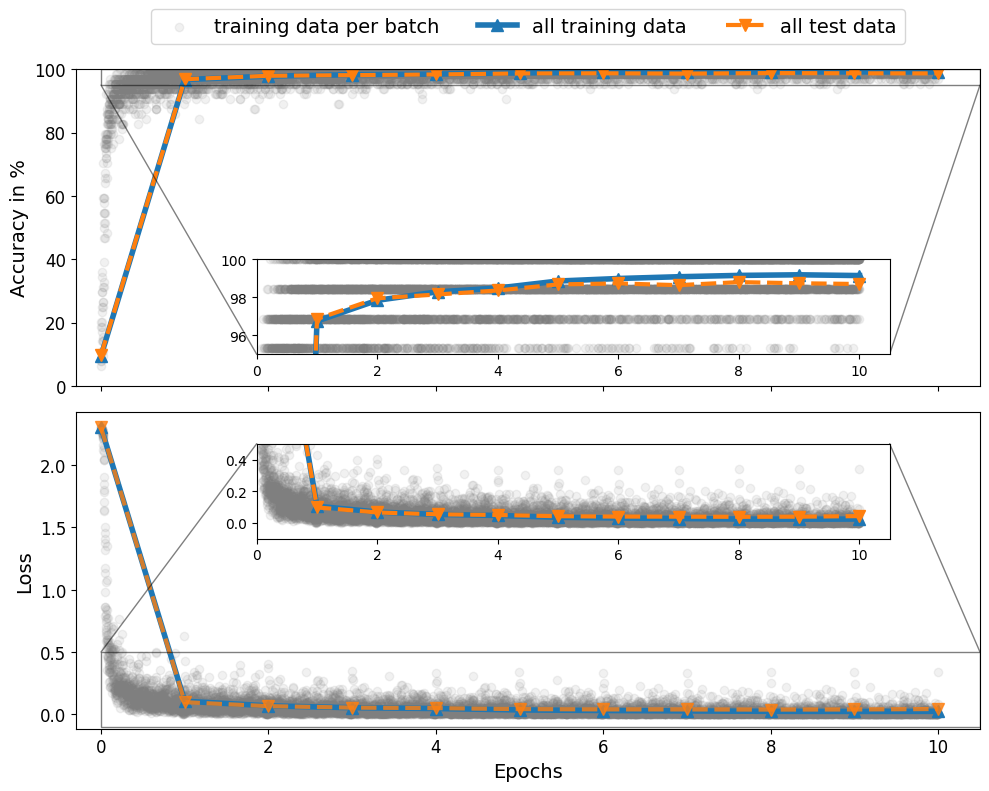

In [12]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

The final accuracy of our convolutional network on the test data after 10 epochs is 98.6 % with a value of the cost function of 0.046. Thus the convolutional network performs significantly better than the fully connected model after 10 epochs of training. Also we observe a smaller discrepancy between the performance on the test data and the performance on the training data, suggesting that the model is more robust against overfitting.

In [13]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.043         0.9870
       10      9380     TRAIN     0.024         0.9915


The total training time of the convolutional model was about 243 seconds, i.e., 4 minutes and 3 seconds. The training took thus a bit longer than for the fully connected model. At first glance the result is a bit surprising, since we have fewer parameters to optimize, but each of the mathematical operations is more complex than the simple linear transformations in the fully connected model and we have many more layers, so it is probably not unreasonable.

In [14]:
print('Total train time was %.0f s' % mynn.get_total_train_time())

Total train time was 272 s


### Convolutional Neural Network with swapped order of activation function and Max pooling

We now investigate what happens if we change the order of the activation function and the max pooling operation. In section 1.3.1 we do this for the ReLU activation, which is a fast to evaluate non-linearity, which performs well in machine learning applications. In section 1.3.2 we will switch over to a Tanh activation function and then consider the effect of swapping activation and maxppoling also for this case in section 1.3.3.

### Swapping the order of ReLU and max pooling

We start by changing the order of activation and maxpooling in our convolutional network:

In [15]:
class ConvNeuralNetworkMNISTSwap(nn.Module):
    def __init__(self):
        super(ConvNeuralNetworkMNISTSwap, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*7*7, 10),
        )
    def forward(self, x):
        logits = self.conv_relu_stack(x)
        return logits

The training is then straightforward and similar to what we have done before.

In [16]:
fname = 'ex131_convnn_swaporder_relu_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTSwap()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

Here we plot the performance data of the convolutional network. We see that the performance metrics are not impacted by swapping the order of the activation and the maxpooling.

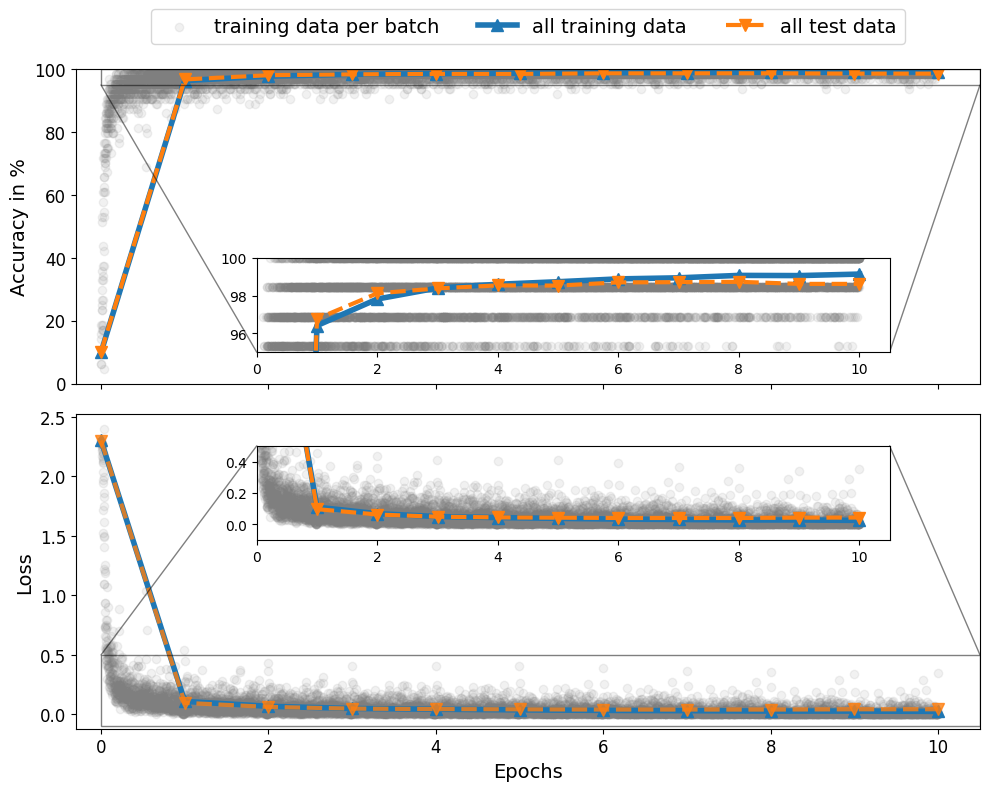

In [17]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

Also the final accuracy of our convolutional network on the test data after 10 epochs is 98.6 % with a value of the cost function of 0.046. Thus the performace after swapping the order of ReLU activation and max pooling is the same as before.

In [18]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.044         0.9862
       10      9380     TRAIN     0.026         0.9914


The total train time is about 220 s, that is 23 s faster than before swapping the order. This can be explained by the fact, that if we apply the activation after maxpooling it is applied to a smaller number of parameters, which means fewer function calls.

In [19]:
print('Total train time was %.0f s' % mynn.get_total_train_time())

Total train time was 238 s


### Building a convolutional neural network with tanh activation

Here we build a convolutional network with tanh activation function and train it with the usual parameters.

In [20]:
class ConvNeuralNetworkMNISTTanh(nn.Module):
    def __init__(self):
        super(ConvNeuralNetworkMNISTTanh, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(32*7*7, 10),
        )
    def forward(self, x):
        logits = self.conv_relu_stack(x)
        return logits

In [21]:
fname = 'ex132_convnn_tanh_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTTanh()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

Judging from the Figure below the performance metrics are not impacted by the switch of the activation function.

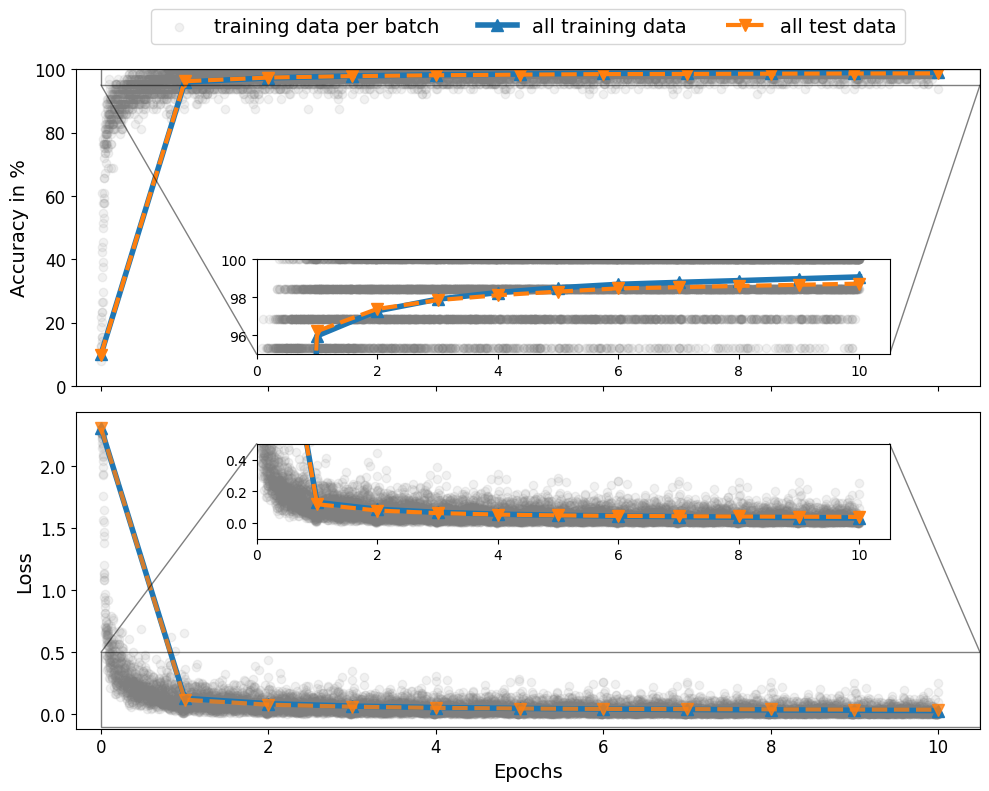

In [22]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

The final accuracy of our convolutional network with Tanh activation is 98.6 % with a value of the cost function of 0.039 on the test data after 10 epochs. Thus the performace is similar to the network with the ReLU activation.

In [23]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.037         0.9872
       10      9380     TRAIN     0.030         0.9907


Surprisingly, the convolutional network with Tanh activation took less time to train than the one with ReLU. This seems strange, since the Tanh activation function is more costly to compute than the ReLU activation and should thus lead to longer run time. Maybe we have here a measuring error or I have loaded the computer in some otehr way during the training of the network making use of the ReLU activation.

In [24]:
print('Total train time was %.0f s' % mynn.get_total_train_time())

Total train time was 365 s


### Swapping the order of tanh activation and max pooling

We now repeat the swapping procedure for the tanh activation function. The resulting network is trained using the usual hyper parameters:

In [25]:
class ConvNeuralNetworkMNISTTanhSwap(nn.Module):
    def __init__(self):
        super(ConvNeuralNetworkMNISTTanhSwap, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(32*7*7, 10),
        )
    
    def forward(self, x):
        logits = self.conv_relu_stack(x)
        return logits

In [26]:
fname = 'ex133_convnn_swaporder_tanh_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTTanhSwap()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

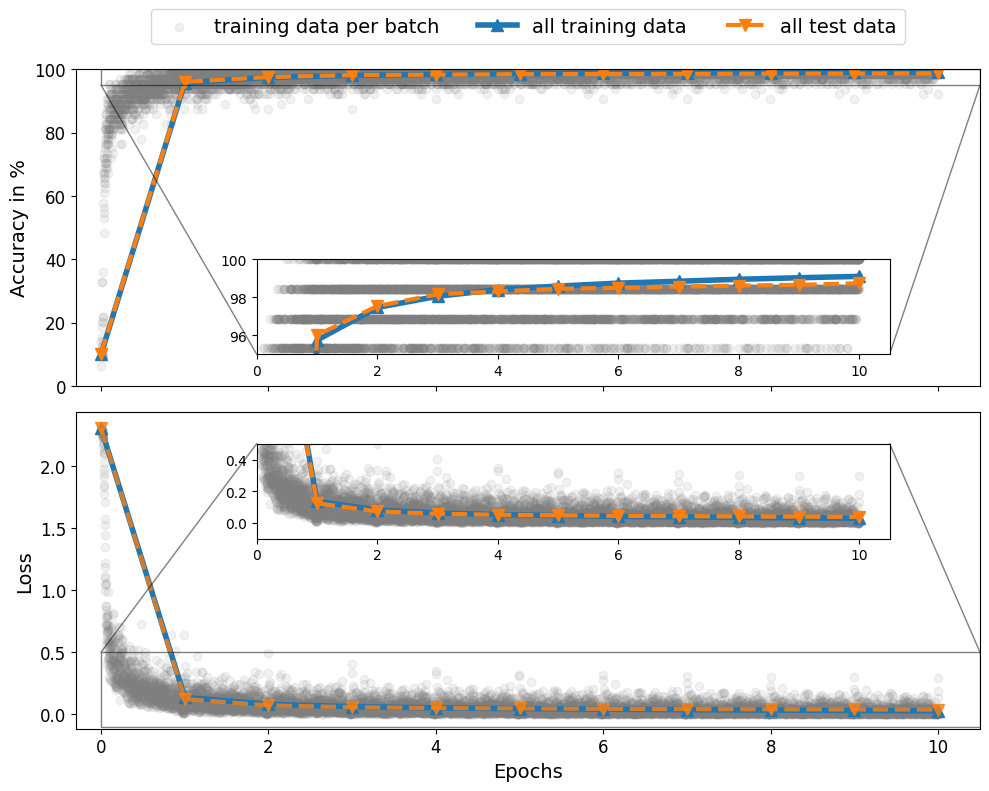

In [27]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

In [28]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.038         0.9874
       10      9380     TRAIN     0.029         0.9910


In [29]:
print('Total train time was %.0f s' % mynn.get_total_train_time())

Total train time was 323 s


### Summary on the effect of swapping the order of activation function and max pooling

Our results here show, that the performance of the model is unchanged by swapping the order of max pooling and the activation function. However, the time it takes to train the model is affected by the order. Having the activation before the max pooling operation results in a longer training time. This can be explained by the fact, that if the max pooling is performed first, the activation function is applied to a smaller amount of data points. Conversely, max pooling is in both cases performed on the same amount of data points, so there is not speed up associated with swapping the order.

## Speeding up the training process with the Adam optimizer

We now use the Adam optimizer instead of the plain SGD algorithm in an attempt to shorten the required training time. 

### Naive swap of optimizer

We try to just swap out the SGD optimizer for the Adam optimizer and keep all other parameters at their previous values:

In [30]:
fname = 'ex141_convnn_swaporder_relu_adam_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_sgd, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTSwap()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

We see that the parameters of the Adam optimizer are at their default values:
- Gradient Decay Factor (β1): 0.9000
- Squared Gradient Decay Factor (β2): 0.9990
- $\epsilon$: $10^{-8}$

In [31]:
print(mynn.optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)


In the Figure below we plot the performance data for using the Adam optimizer. The training is not successful, since the accuracy does not improve and the loss does not decrease. This suggests that we maybe need to doe more than only swapping out the optimizer. A reasonable first guess is, that we could try to reduce the learning rate which we will do in the following section.

(-0.1, 3.0)

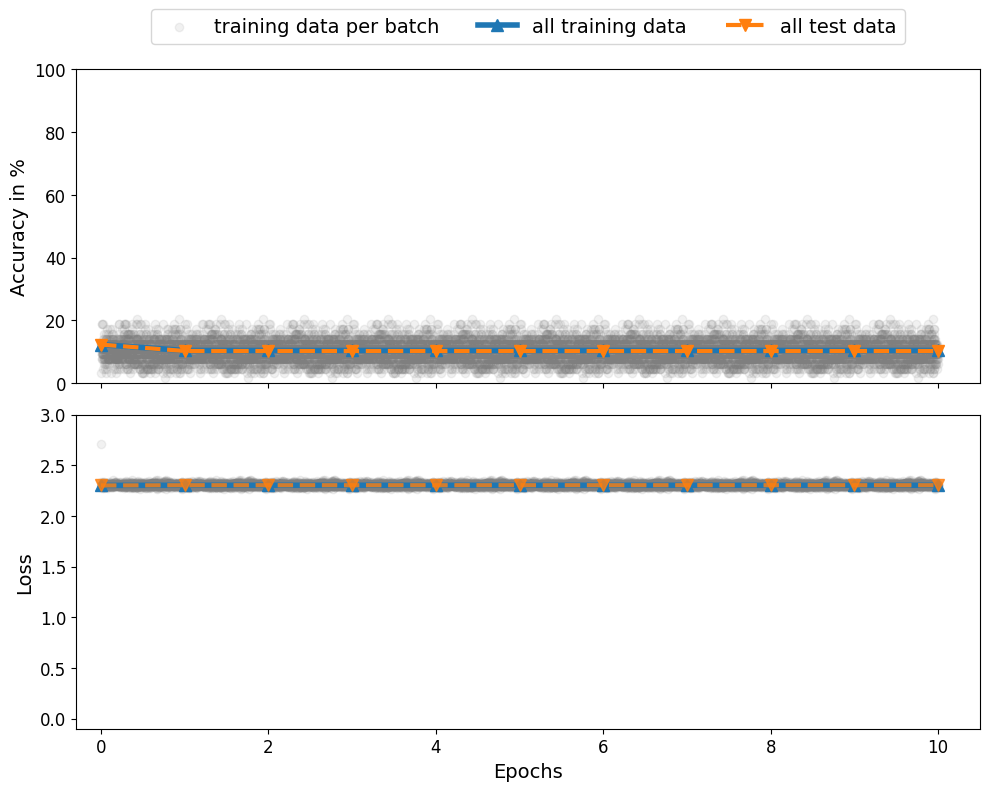

In [32]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train), axins_on=False)
axs[1].set_ylim(bottom=-0.1,top=3)

### Adapting the learning rate

We saw in the previous section that naively swapping the optimizer resulted in a failed training and we suggested that a next step could be to reduce the learning rate. This is what we do here:

In [33]:
lr_adam = 1e-2

Other than that the training is the same as before:

In [34]:
fname = 'ex142_convnn_swaporder_relu_adam_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_adam, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTSwap()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

In the Figure below we visualize the performance of the model as a function of the epoch. An accuracy of over 96 % is reached after only one epoch. Judging from the batch training data (grey circles), probably much earlier than that, but we are not able to say from this data how much earlier as we do not evaluate on the test data after each iteration.

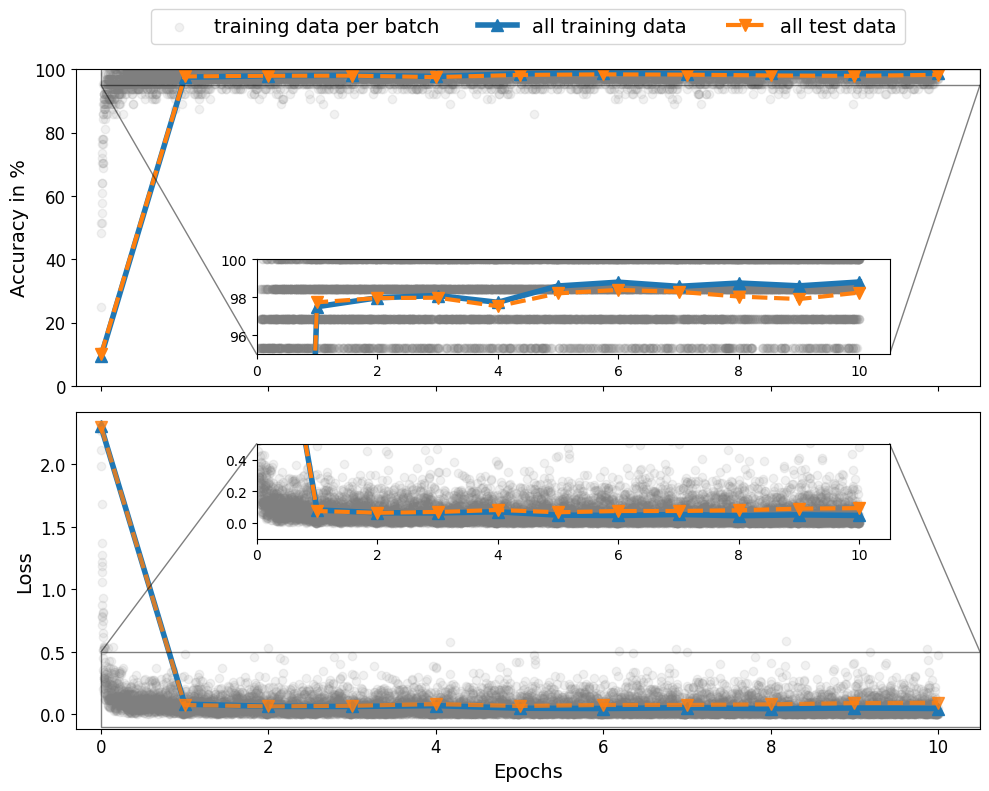

In [35]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

The final performance of the model is an accuracy of 98 % after 10 epochs of training. This is not as good as the accuracy we observe for the SGD optimizer with a learning rate of 1e-1. this suggests, that there is further room for tuning hyper parameters for the Adam optimizer.

In [36]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.093         0.9825
       10      9380     TRAIN     0.047         0.9881


For consistency, we compare also to the case where we have a smaller learning rate in the SGD algorithm:

In [37]:
fname = 'ex142_convnn_swaporder_relu_sgd_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_adam, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTSwap()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_adam)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

The Figure below visualizes that the training is much slower than with the adam optimizer. After 6 epochs an accuracy over 96 % is reached and 98 % are not reached after 10 epochs.

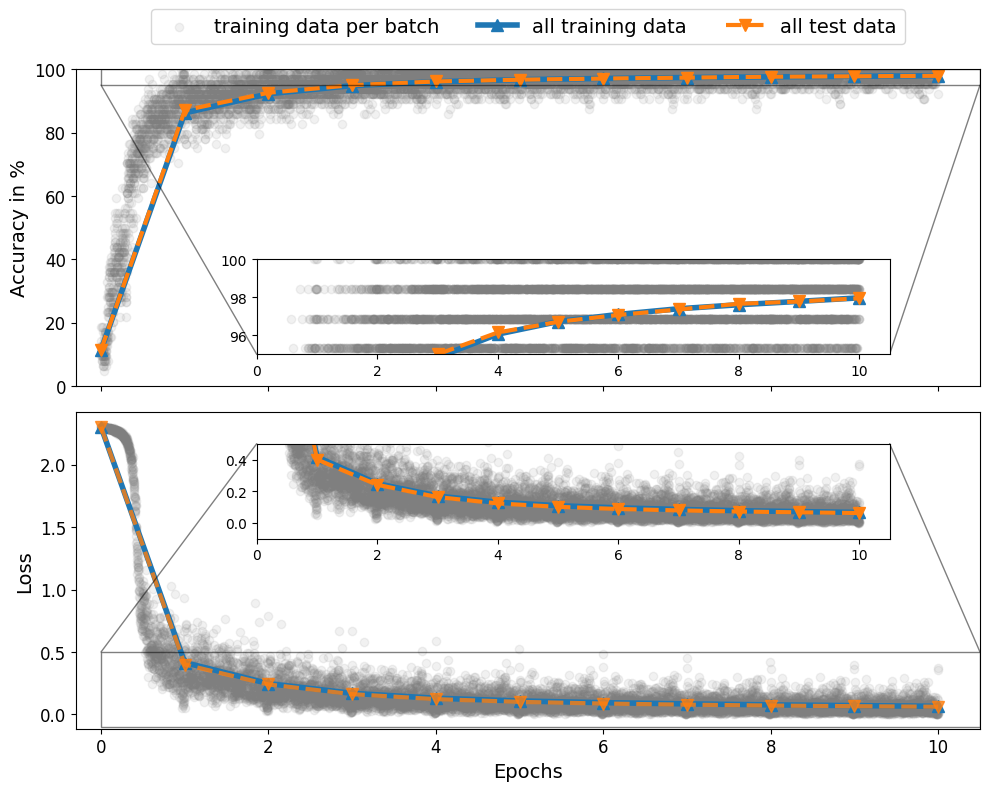

In [38]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

The final performance after 10 epochs of training is 98.0 % on the test data. This is somewhat lower than the accuracy we observed for the Adam optimizer and quite a bit lower than the accuracy we observed for the SGD optimizer with a learning rate of 1e-1.

In [39]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.062         0.9795
       10      9380     TRAIN     0.066         0.9797


## Improving the model

As a last exercise, we consider some improvements to our convolutional neural network model. We consider improvements by dropout, batch normalization and increasing the number of filters in the convolution operations.

### Dropout

Here we consider regularization using Dropout. The network definition becomes then:

In [40]:
class ConvNeuralNetworkMNISTSwapDropout(nn.Module):
    
    def __init__(self, p=0.5):
        super(ConvNeuralNetworkMNISTSwapDropout, self).__init__()
        self.maxpool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=p)
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32*7*7, 10)
    
    def forward(self, x):
        x = self.conv0(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        logits = self.dropout(x)
        return logits

We see that we need to first find a good parameter for the dropout probability $p$. Furthermore we have seen in the previous section that the Adam optimizer requires a bit of fiddling with the learning rate and droput adds additional statistical noise to the training. After some experimentation we have settled on the following values fpr the learning rate and $p$:

In [41]:
lr_dropout = 1e-3
p_dropout = 0.25

The training is apart from the changes to the learning rate similar to what we have done before:

In [42]:
fname = 'ex151_convnn_swaporder_relu_adam_dropout%.2f_%iepochs_lr%.4f_bs%i.pkl' \
        % (p_dropout, nepochs, lr_dropout, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTSwapDropout(p_dropout)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_dropout)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

As usual we plot the performance of the model in the Figure below. We notice several interesting things: first of all we have virtually eliminated the problem of overfitting to the training dataas the performance on training and test data are pretty much the same in every epoch. Secondly, it seems that we reach much better accuracy on all data than on any individual batch of the training set. That is likely the effect of droput, which seems to introduce an "offset" between the running average of the performance on the batched training data and the performance observed on the whole training and test data.

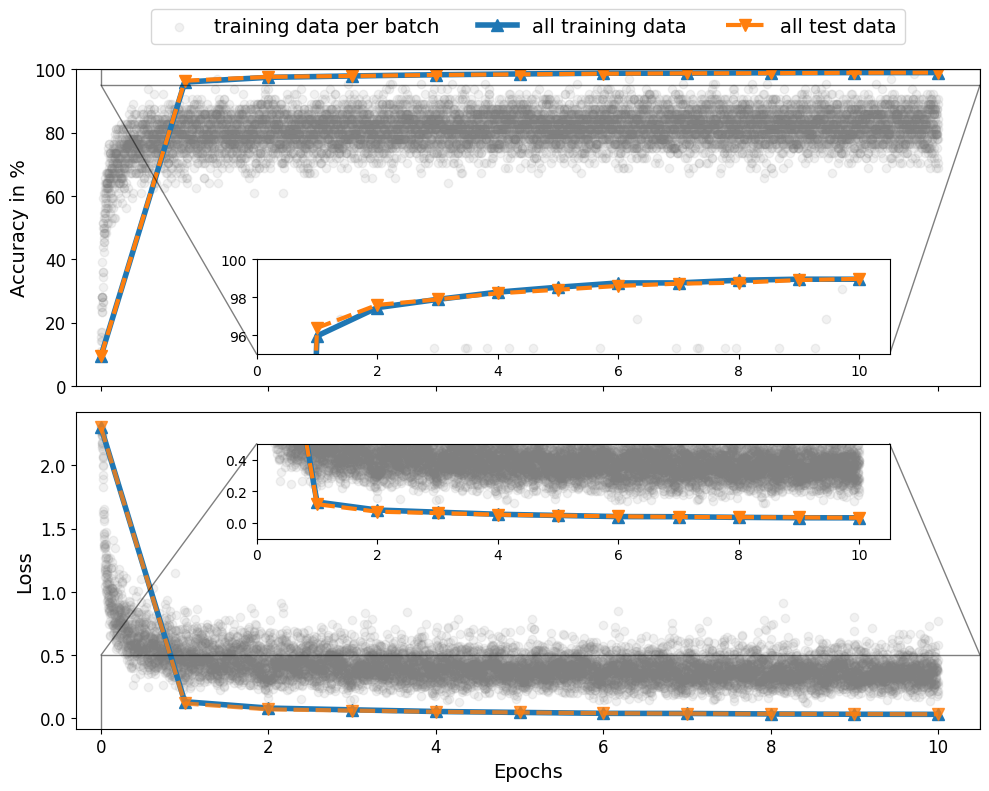

In [43]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

The final accuracy on the test data was 99.0 % after 10 epochs. This is the best accuracy we have reached thus far!

In [44]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.032         0.9897
       10      9380     TRAIN     0.032         0.9895


### Batch normalization

We now add batch normalization to our network in an attempt to regularize the loss landscape and help the optimizer find a better minimum. The architecture of the networ reads then (we do not use dropout here):

In [45]:
class ConvNeuralNetworkMNISTSwapBatchNorm(nn.Module):
    
    def __init__(self):
        super(ConvNeuralNetworkMNISTSwapBatchNorm, self).__init__()
        self.maxpool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU(inplace=True)
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn0 = nn.BatchNorm2d(8)
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32*7*7, 10)
    
    def forward(self, x):
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.flatten(x)
        logits = self.fc(x)
        return logits

We train the network with the Adam optimizer and the hyperparameters we have found earlier:

In [46]:
fname = 'ex152_convnn_swaporder_relu_adam_batchnorm_%iepochs_lr%.4f_bs%i.pkl' \
        % (nepochs, lr_dropout, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTSwapBatchNorm()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_dropout)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fname)

After 10 epochs of training the final accuracy on the test data is 98.8 %, which is slightly lower than for the case with dropout, but still quite a bit better than what we observed before adding batch normalization.

In [47]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       10      9380      TEST     0.045         0.9879
       10      9380     TRAIN     0.013         0.9955


In the figure below we show the performance metrics of our model as a function of the epoch. We see that batch normalization gets the model to reach accuracy beyond 98 %, but does not eliminate overfitting. In the following it will thus be interesting to see what we can gain by combining the two and increasing the size of the network.

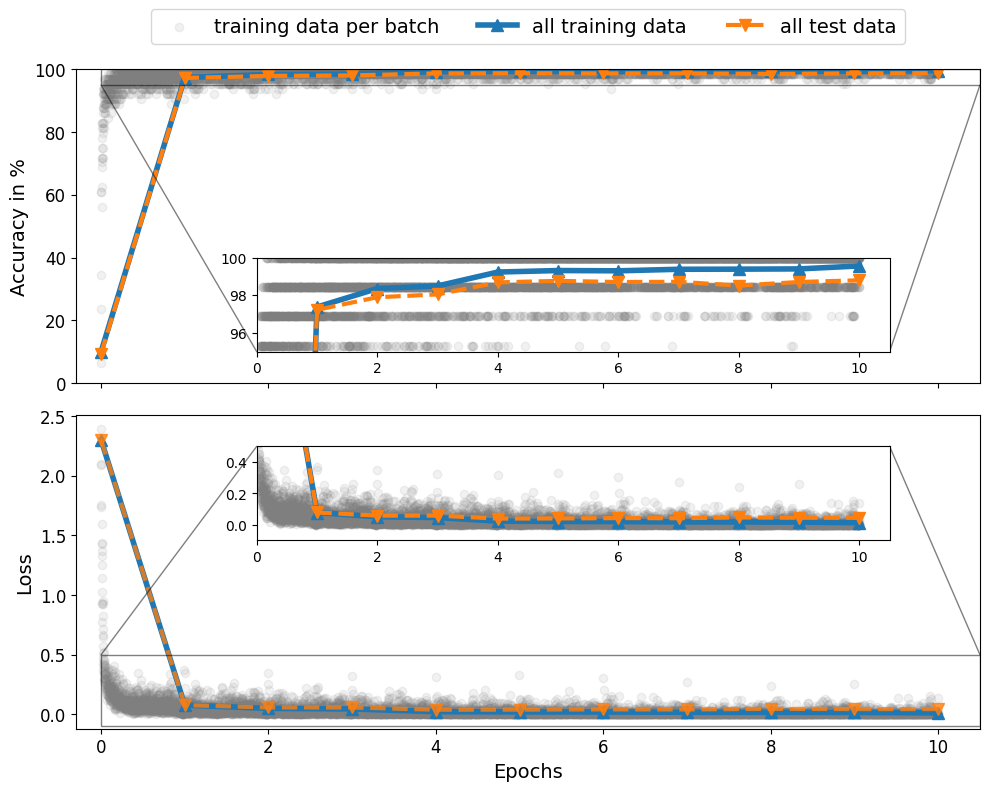

In [48]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

### Going bigger

In this section we increase the number of output channels in each convolution operation. In this way we can increase the number of features the network is able to recognize. This can create a problem of overfitting to the data, since we have more parameters, which can pick up more specifics of the training set. In order ot counteract that we add dropout and since we saw better accuracy using batch noramlization in the previous section, we also add batch normalization after each convolution layer.

In [49]:
class ConvNeuralNetworkMNISTSwapDropoutBatchNormBig(nn.Module):
    
    def __init__(self, p=0.5):
        super(ConvNeuralNetworkMNISTSwapDropoutBatchNormBig, self).__init__()
        self.maxpool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=p)
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64*7*7, 10)
    
    def forward(self, x):
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        logits = self.dropout(x)
        return logits

Through experimentation we have settled on the following parameters for the training process:

In [50]:
lr_dropout_153 = 5e-4
p_dropout_153 = 0.4
nepochs_153 = 20

In [51]:
fname = 'ex153_convnn_swaporder_relu_adam_dropout%.2f_batchnorm_big_%iepochs_lr%.4f_bs%i.pkl' \
        % (p_dropout_153, nepochs_153, lr_dropout_153, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = ConvNeuralNetworkMNISTSwapDropoutBatchNormBig(p_dropout_153)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_dropout_153)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train,
                               dataloader_test, device=device)
    mynn.train(nepochs=nepochs_153)
    mynn.to_disk(fname)

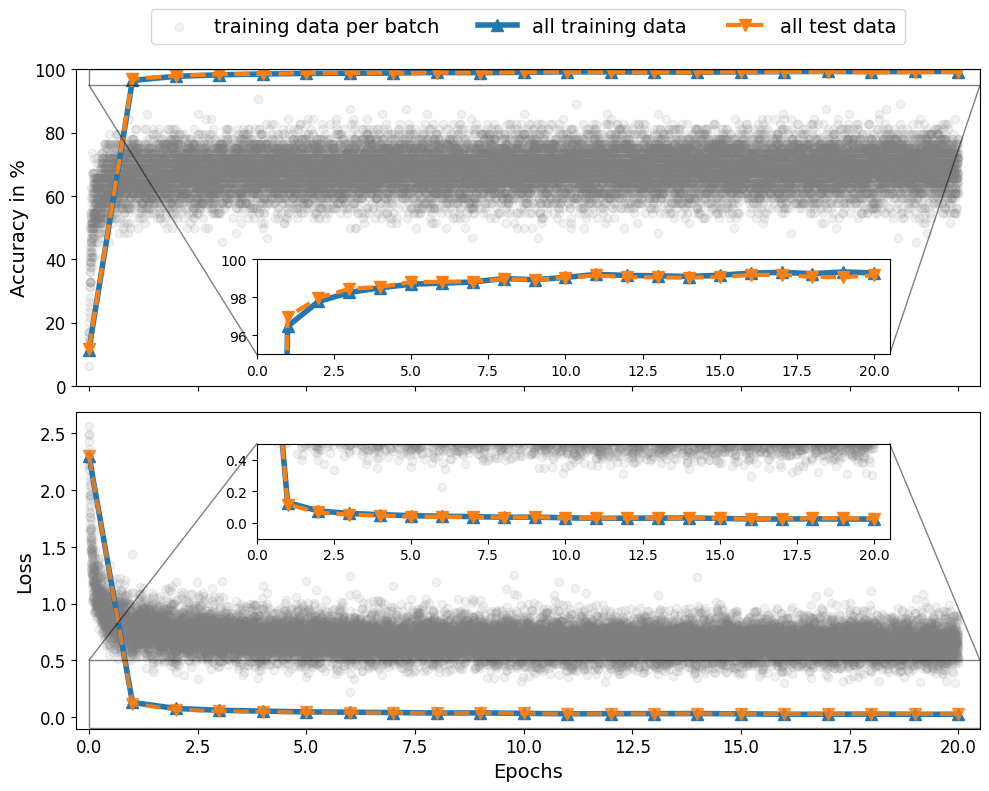

In [52]:
fig, axs, axins = mpf.plot_acc_loss_MNIST(mynn.log2pandas(), len(mynn.dataloader_train))

The final accuracy after 20 epochs of training is 99.3 % on the test data.

In [53]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST       ACCURACY
       20     18760      TEST     0.026         0.9916
       20     18760     TRAIN     0.024         0.9928


### The best model -- confusion matrix and examples

The model in the previous section was the best model we were able to train. So let's have a look at what images the network still misclassifies. Maybe we can see in this way if there is a certain handwritten number, which is harder for the network to classify. We start by getting the network's predictions and the correct numers:

In [54]:
y_pred = []
y_true = []

for X, y, index in dataloader_test:
    y_pred.append(mynn.predict_onehot(X))
    y_true.append(y)
y_pred = torch.cat(y_pred).cpu().numpy()
y_true = torch.cat(y_true).cpu().numpy()

Now using the useful function `ConfusionMatrixDisplay.from_predictions()` from `sklearn` we can obtain a visualization of the confusion matrix of our model shown below. We see that the majority of images are correctly identified (those long the diagonal of the matrix). But there are certain handwritten numbers, which are harder for the network to correctly identify: 0 and 1 for example are often misclassified as 6. 4 and 5 are often identified as 9. But also the converse happens, i.e., the 9 is sometimes misclassified as a 4.

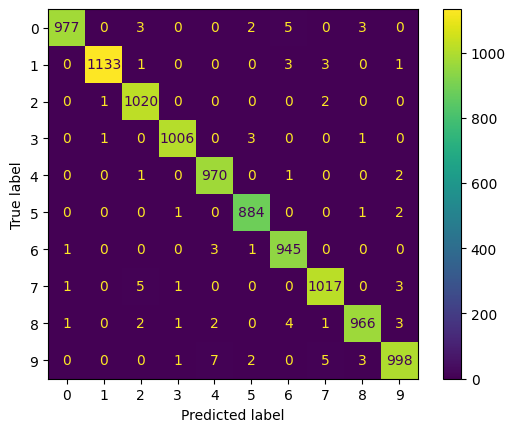

In [55]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_true)

But how do the images look like, which are misclassified? Can we spot some systematics? We show below all the images, which are are not correctly classfied by the model. Some of the images a human would also have difficulty classifying correctly, such as the image second image in the top row, which the model classified as 6, but whoose correct class is 0. Other images such as the second last image from the left in the top row is easy to classify for a human, whereas the model struggles. Overall it seems that the model struggles with numbers, which are slanted, slightly rotated or contain some small features, that make the difference to another class.

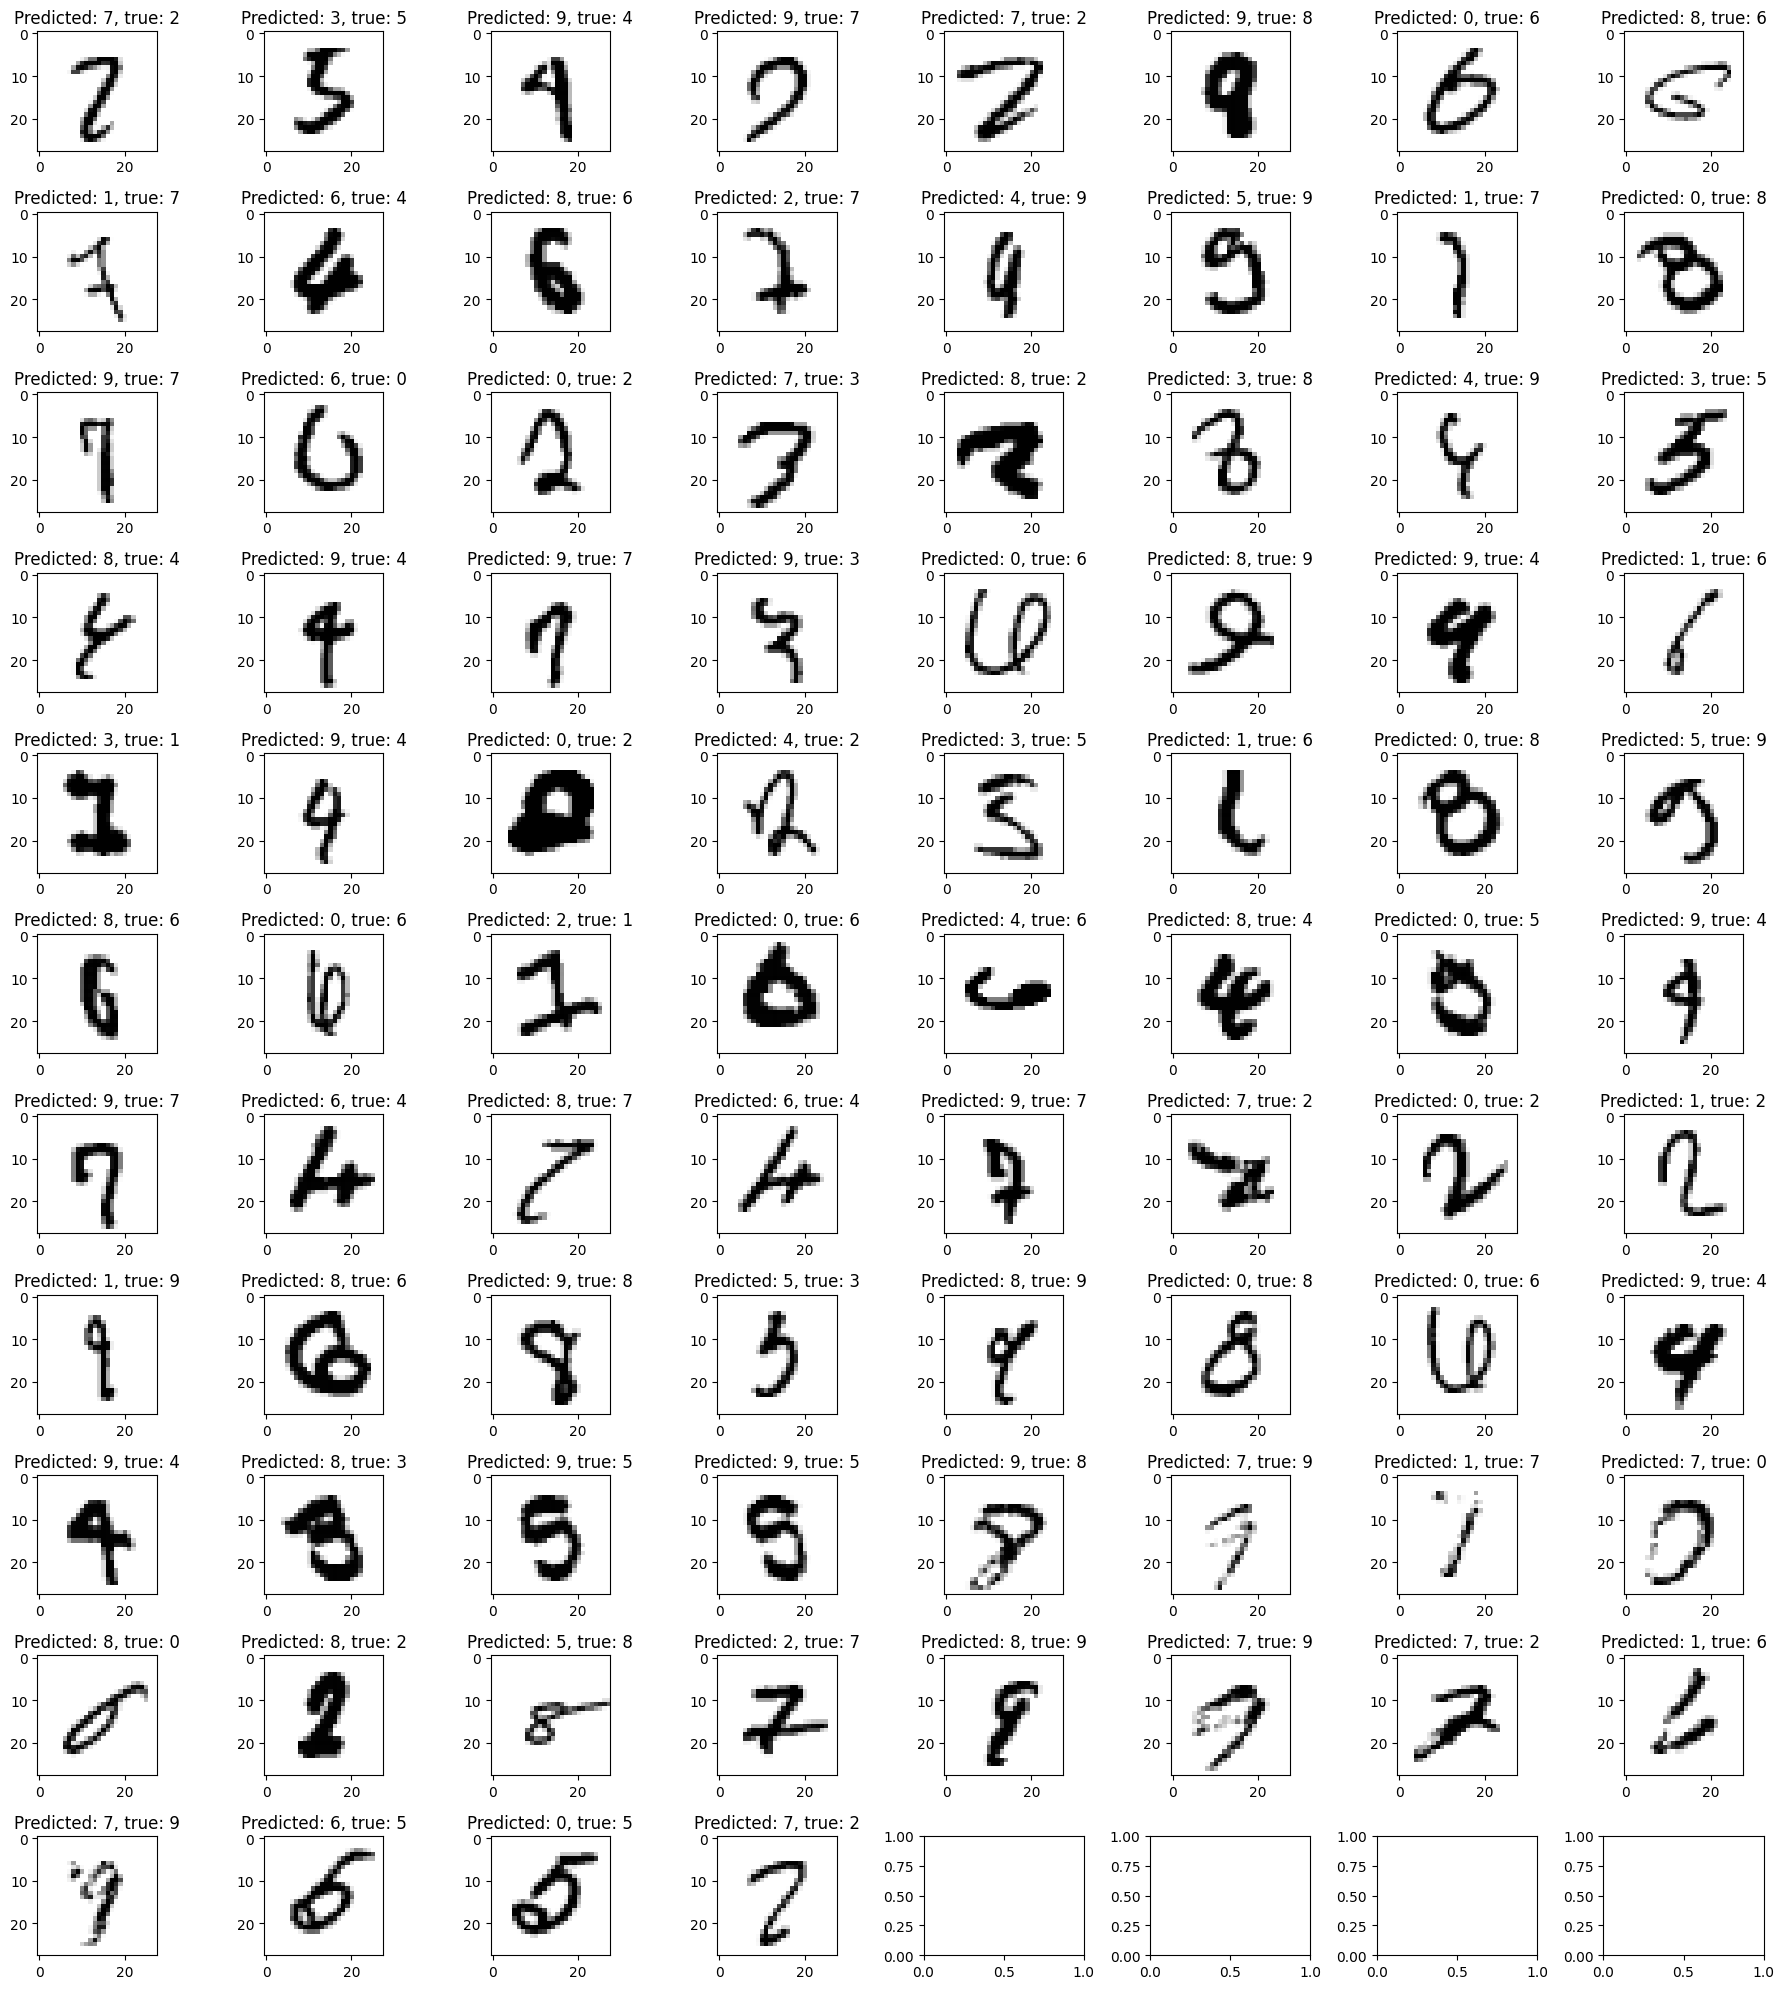

In [56]:
mask = (y_true != y_pred)
fig, axs = plt.subplots(np.ceil(mask.sum()/8.).astype(int), 8, figsize=(18,20))

X_false = np.array([dataloader_test.dataset[ix][0].numpy() for ix in np.where(mask)[0]])
y_false = y_pred[mask]
y_true2 = y_true[mask]

for X, y, yt, ax in zip(X_false, y_false, y_true2, axs.ravel()):
    ax.set_title('Predicted: %i, true: %i' % (y, yt))
    ax.imshow(X[0,:,:], cmap='binary')

fig.tight_layout()

---
---

# Semantic segmentation of Biomedical images

In this second part of the assginment we are looking into the segmentation of Hematoxylin and Eosin stained microscopy slides of colorectal cancer. Each image of the Warwick dta set shows thereby glands, which are assemblies of cells that synthesize substances in the human body. The shape of these glands is commonly used to assess the degree of malignancy of several adenocarcinomas, including prostate, breast, lung, and colon cancers.

Our job is to segment these images into regions where there is a gland (pixel value 1) and regions where there are no glands (pixel value 0). Each image is a two-channel image of size 128x128 pixels with the blue channel equal to zero everywhere.

As a first step we need to load the data. In order to minimize the number of parameters and lower memory consumption, we load only 2 channels. The input to our network are then arrays of size 2x128x128. We define here a custom transform `ImgToTensor2Channels()` which we can apply to our dataset to that end. Furthermore the documentation of the `CrossEntropyLoss()` function in Pytorch (see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) specifes that the target needs to be of shape 128x128 and contain for each pixel only the class number (0 or 1). Furthermore the data type needs to be a 64-bit integer. We define here the transform `TargetTransformCrossEntropy()`, which performs the necessary operations on the data.

In [57]:
class ImgToTensor2Channels():
    def __init__(self, transform=transforms.ToTensor()):
        self.transform = transform

    def __call__(self, img):
        img = self.transform(img)
        return img[:2,...]


class TargetTransformCrossEntropy():
    def __call__(self, target):
        tmparr = np.array(target)  # Needs to have shape HxW
        return torch.as_tensor(tmparr.astype(np.double)/255., dtype=torch.int64)

Now we are ready to load the data. To that end we have built a customized dataset class `WarwickDataset()`, which performs the loading of all images and allows to specify the transforms we want to use on the images and on the label masks, i.e., in our case the transformations we have defined above. The following lines load the data:

In [58]:
batch_size_train_ww = 8          # batch size during training
batch_size_test_ww = 32          # batch size for the test data

train_data_ww = dh.WarwickDataset('WARWICK/Train', transform=ImgToTensor2Channels(),
                                  target_transform=TargetTransformCrossEntropy())

test_data_ww = dh.WarwickDataset('WARWICK/Test', transform=ImgToTensor2Channels(),
                              target_transform=TargetTransformCrossEntropy())

dataloader_train_ww = DataLoader(train_data_ww, batch_size=batch_size_train_ww, shuffle=True)
dataloader_test_ww = DataLoader(test_data_ww, batch_size=batch_size_test_ww, shuffle=True)

## Designing a network for semantic segmentation

Now we need to modify the network from the MNIST classification task for image segmentation. We then need to adapt the convolutional layers to the input size of 2x128x128, so the first convolution needs to have 2 input channels. The convolutions and maxpooling layers reduce the size of the data in the spatial directions, but increase the size in channel direction. So we need to use transposed convolutions to restore the image to its original size and one last 1x1 convolution as a replcaement for the fully connected layer before the classification output. Following these ideas we will start with the following network:

In [59]:
class NeuralNetworkWarwick(nn.Module):
    def __init__(self):
        super(NeuralNetworkWarwick, self).__init__()
        self.nn_stack = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0),
        )
    
    def forward(self, x):
        logits = self.nn_stack(x)
        return logits

Now we see that our network does not output class proababilities in channel direction, but unnormalized logits. In order to deal with this in a uniform way our custom neural network abstraction, we define here a class, which transforms the logits into class probabilities using the `Sotfmax2d()` function in Pytorch.

In [60]:
class LogitsToProbabilitiesImageSegmentation():
    
    def __init__(self):
        self.softmax = nn.Softmax2d()
    
    def __call__(self, logits):
        return self.softmax(logits)

Furthermore we need another measure of the prediction accuracy of our network. To that end we use the Sørensen-Dice coefficient (DSC), which measures the mutual agreement of two sets or images. A DSC of 1 means perfect agreement, while a DSC of 0 means perfect disagreement between the sets, i.e., the overlap between the sets is zero. In order to use this criterion in our custom neural network abstraction, we define:

In [61]:
class SorensenDiceCriterion():

    def __init__(self):
        self.name = "dsc"
        self.onehot = mnn.OneHotEncoding()

    def __call__(self, logits, target, full=False):
        a = self.onehot(logits).bool()
        b = target.bool()
        intersect = torch.logical_and(a,b)
        dice_coeff = (2.0 * intersect.sum(dim=(-1,-2))) / (a.sum(dim=(-1,-2)) + b.sum(dim=(-1,-2)))
        return [dice_coeff.cpu().numpy()]

Now we are in a position to start training the network. To that end we use the following parameters and batch sizes:

In [62]:
lr_adam_ww = 5e-4                # learning rate for Adam optimizer
nepochs_ww = 100                 # number of epochs to run the training

In [63]:
fname = 'ex21_convnn_warwick_%iepochs_lr%.4f_bs%i.pkl'% (nepochs_ww, lr_adam_ww, batch_size_train_ww)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = NeuralNetworkWarwick()
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww, dataloader_test_ww, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww)
    mynn.to_disk(fname)

We show the performance metrics of the model as a function of the epoch in the Figure below. In the beginning, both cost and DSC are quite similar between the training and test datasets. However from about epoch 20 onwards, both performance metrics improve more for the training data than for the test data. This suggests that we have quite an overfitting problem with our model.

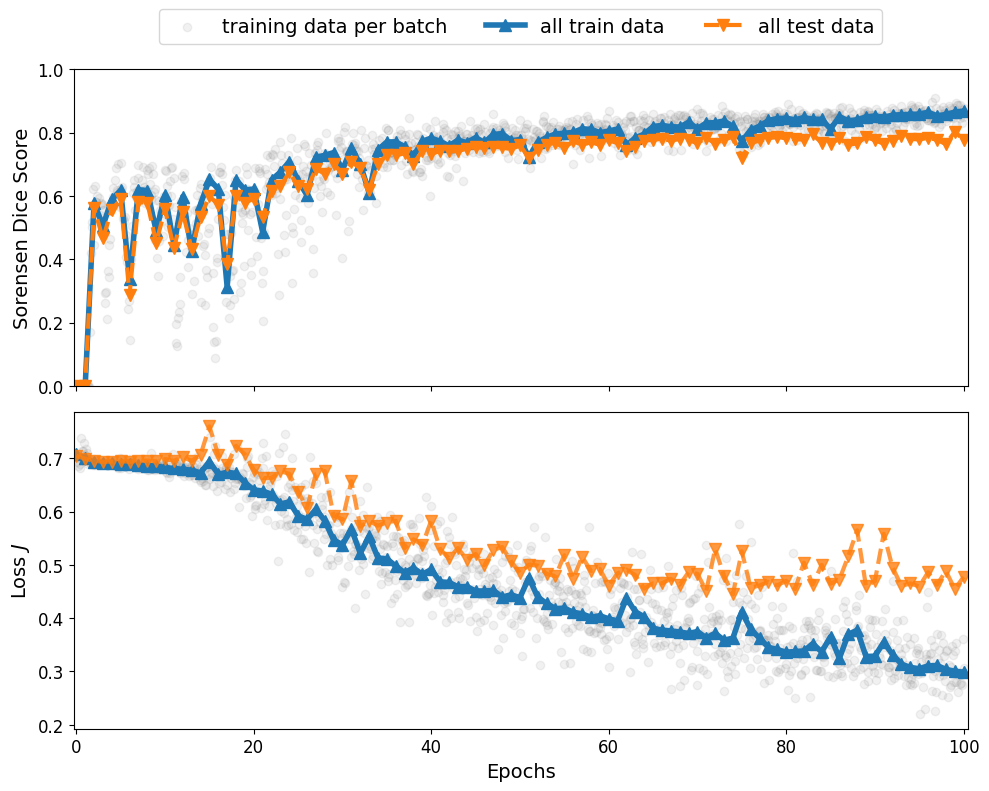

In [64]:
fig, axs, axins = mpf.plot_acc_loss_ww(mynn.log2pandas(), len(mynn.dataloader_train))

After 100 epochs of training, the final performance of the model was a DSC of 77.8 % on the test data.

In [65]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST            DSC
      100      1100      TEST     0.477         0.7781
      100      1100     TRAIN     0.299         0.8681


### Inspecting the predicted maps

We will now visually inspect some of the predicted maps and compare them to the ground truth given by the label mask. In order to do so, we first retrieve the value of the DSC for all images on the test partition and sort them in ascending order. Furthermore we create the arrays `X` and `Y`

In [66]:
df = mynn.log2pandas()
crit = df[df.dataset == 'test'].criterion.iloc[-1]
idx = np.argsort(crit)
crit = crit[idx]
X = [dataloader_test_ww.dataset[i][0] for i in idx]
y = [dataloader_test_ww.dataset[i][1] for i in idx]

We take a look at the prediction corresponding to the last, the 20th and first index of our new arrays. These indices correspond to the best DSC, some intermediate value and the worst DSC on the whole test data partition. We plot the resulting segemnted maps together with the ground truth in the Figure below. It seems that the network is doing pretty well for rather large and round glands that are well separated and cover the whole imaged region. If the glands get too small or the separation is less clear, the network fares worse. The worst case scenario seems to be glands, which are not round, but more irregular and which do not cover the whole image.

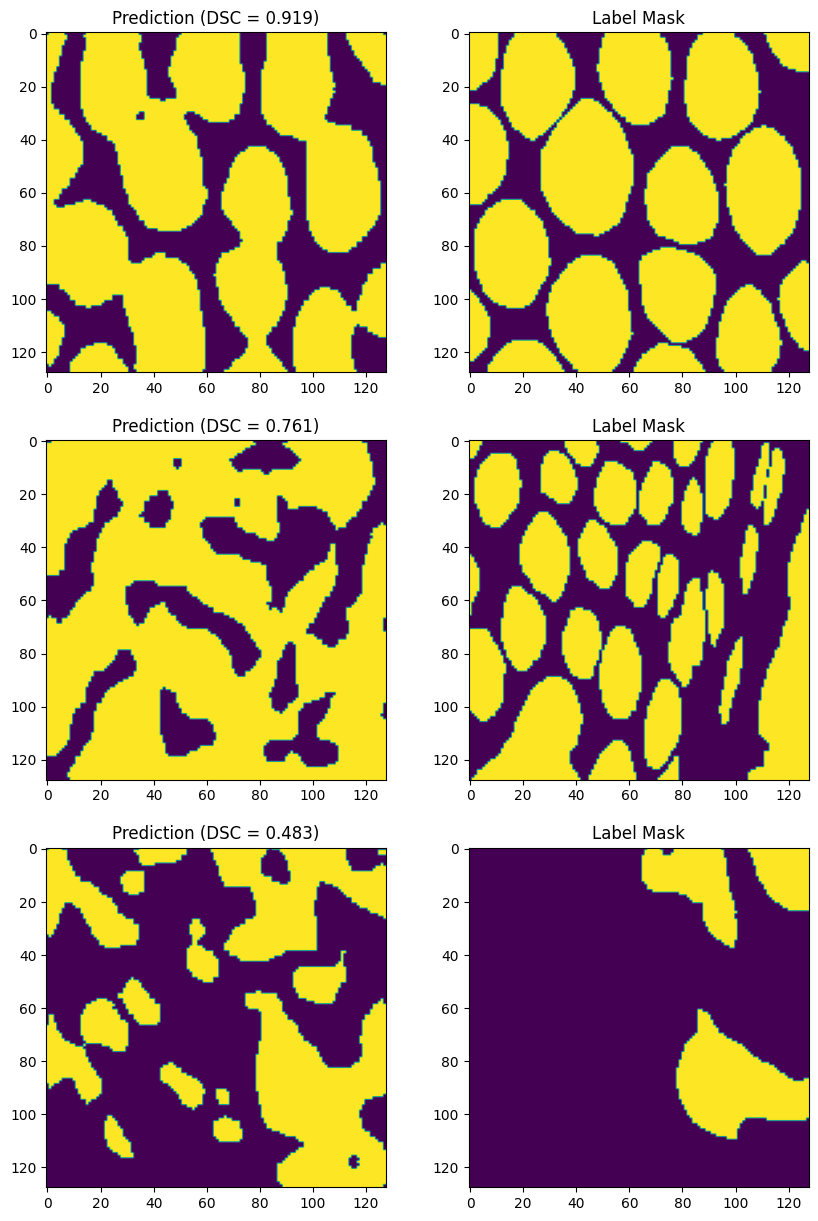

In [67]:
index = -1

fig, axs = plt.subplots(3, 2, figsize=(10,15))

for ii, index in enumerate((-1, 20, 0)):
    onehot_pred = mynn.predict_onehot(X[index][None, :, :, :])
    
    axs[ii,0].set_title('Prediction (DSC = %.3f)' % crit[index])
    axs[ii,0].imshow(onehot_pred.cpu().reshape(128, 128))
    axs[ii,1].set_title('Label Mask')
    axs[ii,1].imshow(y[index])

## Improving the network performance on unseen data

Now we will investigate ways of improving the performance on unseen data. 

### Batch Normalization

To start off, we consider what we can achieve by adding batch normalization to the network:

In [68]:
class NeuralNetworkWarwickBatchNorm(nn.Module):
    def __init__(self):
        super(NeuralNetworkWarwickBatchNorm, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU(inplace=True)
        self.downconv_0 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.downconv_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.downconv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.downconv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.upconv_0 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.upconv_1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(16)
        self.upconv_2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(8)
        self.output = nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        x = self.downconv_0(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.downconv_1(x)
        x = self.bn2(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.downconv_2(x)
        x = self.bn3(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.downconv_3(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.upconv_0(x)
        x = self.bn5(x)
        x = self.upconv_1(x)
        x = self.bn6(x)
        x = self.upconv_2(x)
        x = self.bn7(x)
        logits = self.output(x)        
        return logits

We train the network with the same parameters as before:

In [69]:
fname = 'ex21_convnn_warwick_batchnorm_%iepochs_lr%.4f_bs%i.pkl'% (nepochs_ww, lr_adam_ww, batch_size_train_ww)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = NeuralNetworkWarwickBatchNorm()
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww, dataloader_test_ww, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww)
    mynn.to_disk(fname)

In the Figure below we show the performance metrics of the model as a function of epoch. We see that we have managed to regularize the loss landscape, since the optimizer approaches the minimum in a more "smooth way" than before we added the batch normalization. However, the smoother loss landscape also leads to a stronger overfitting on the training data.

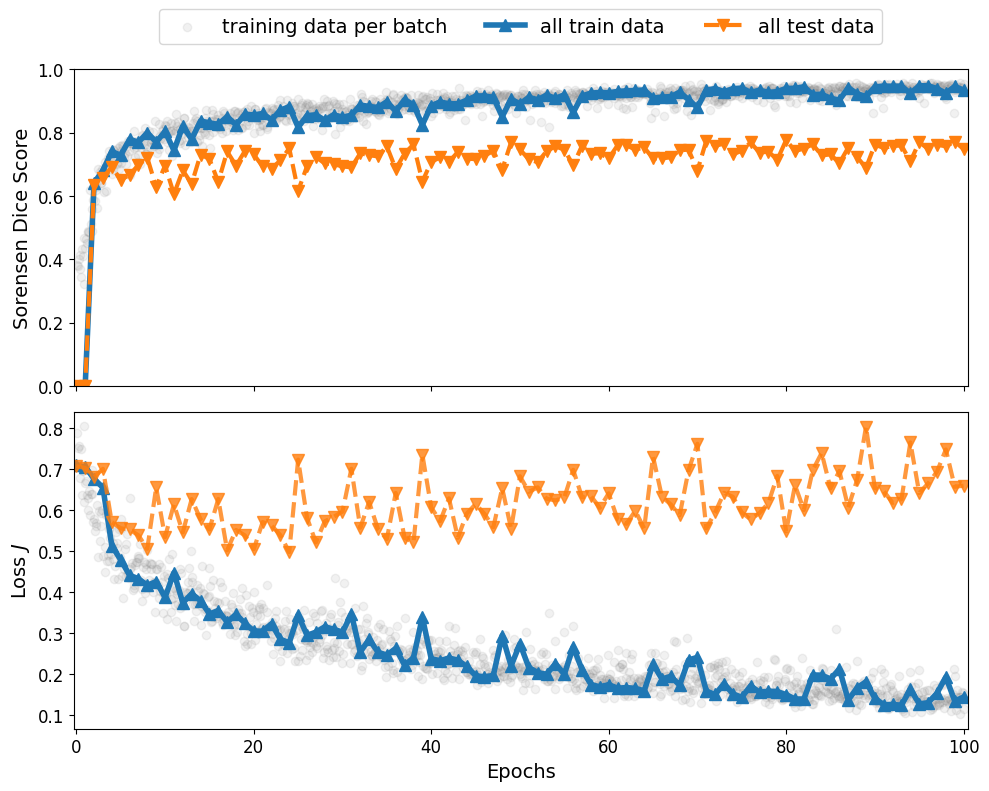

In [70]:
fig, axs, axins = mpf.plot_acc_loss_ww(mynn.log2pandas(), len(mynn.dataloader_train))

The final DSC of our model is 0.748 after 100 epochs of training which is a bit lower than what we obtained before batch normalization:

In [71]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST            DSC
      100      1100      TEST     0.660         0.7479
      100      1100     TRAIN     0.143         0.9342


### Batch Normalization and Dropout

We saw in the previous section, that overfitting was a problem after adding batch noarmalization to the network. In order to counteract that, we add here dropout in an attempt to reduce the overfitting and improve the performance.

In [72]:
class NeuralNetworkWarwickDropoutBatchNorm(nn.Module):
    def __init__(self, p=0.5):
        super(NeuralNetworkWarwickDropoutBatchNorm, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=p)
        self.downconv_0 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.downconv_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.downconv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.downconv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.upconv_0 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.upconv_1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(16)
        self.upconv_2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(8)
        self.output = nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0)
        
    
    def forward(self, x):
        x = self.downconv_0(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.downconv_1(x)
        x = self.bn2(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.downconv_2(x)
        x = self.bn3(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.downconv_3(x)
        x = self.bn4(x)
        x = self.upconv_0(x)
        x = self.bn5(x)
        x = self.upconv_1(x)
        x = self.bn6(x)
        x = self.upconv_2(x)
        x = self.bn7(x)
        logits = self.output(x)        
        return logits

We choose a dropout probability of 50 %,

In [73]:
p_dropout_ww = 0.5

and the training is then straightforward:

In [74]:
fname = 'ex21_convnn_warwick_dropout_batchnorm_%iepochs_lr%.4f_bs%i.pkl'% (nepochs_ww, lr_adam_ww, batch_size_train_ww)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = NeuralNetworkWarwickDropoutBatchNorm(p_dropout_ww)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww, dataloader_test_ww, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww)
    mynn.to_disk(fname)

In the Figure below we shoe the performance metrics of the network as a function of epoch. The overfitting problem has indeed been reduced a bit, but the model continues to perform quite a bit better on the training data than on the test data.

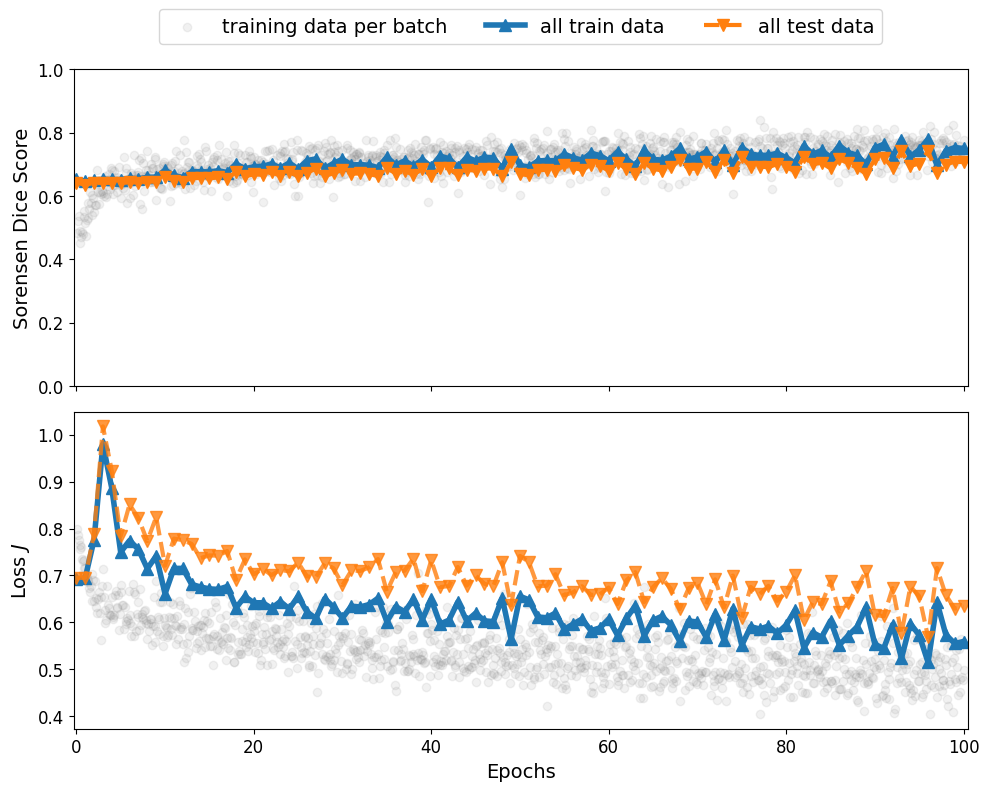

In [75]:
fig, axs, axins = mpf.plot_acc_loss_ww(mynn.log2pandas(), len(mynn.dataloader_train))

The final DSC after 100 epochs is 0.707 which is smaller than what we have obtained before with pure batch normalization and with our original network. This suggests that there is some space for parameter tuning here.

In [76]:
mynn.print_performance(dataset=['test', 'train'], header=True)

    EPOCH ITERATION   DATASET      COST            DSC
      100      1100      TEST     0.634         0.7067
      100      1100     TRAIN     0.559         0.7499


### Hyperparameter tuning

To that end we first split the training data into a validation set and a training set, so we can tune the hyper parameters of our model without risking to optimize them for the test set.

In [77]:
# Define the ratio for splitting the data (e.g., 80% for training, 20% for validation)
train_ratio = 0.8
val_ratio = 0.2

# Compute the number of samples for each split
train_size = int(train_ratio * len(train_data_ww))
val_size = len(train_data_ww) - train_size

# Split the dataset into training and validation sets
dataset_train_ww_split, dataset_val_ww_split = random_split(train_data_ww, [train_size, val_size])

# Create data loaders for training and validation sets
dataloader_train_ww_split = DataLoader(dataset_train_ww_split, batch_size=batch_size_train_ww, shuffle=True)
dataloader_val_ww_split = DataLoader(dataset_val_ww_split, batch_size=batch_size_test_ww, shuffle=False)

We have then experimented with different settings of the parameters and found that the following combination yielded good results:

In [78]:
lr_adam_ww_tuned = 1e-3
p_dropout_ww_tuned = 0.25
nepochs_ww_tuned = 100

The training is as usual:

In [79]:
fname = 'ex21_convnn_warwick_dropout%.2f_batchnorm_tuned_%iepochs_lr%.4f_bs%i.pkl'% (p_dropout_ww_tuned, nepochs_ww_tuned, lr_adam_ww_tuned, batch_size_train_ww)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = NeuralNetworkWarwickDropoutBatchNorm(p_dropout_ww_tuned)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww_split, dataloader_val_ww_split, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww_tuned)
    mynn.to_disk(fname)

We display the performance metrics of the optimized network in the figure below. We have some overfitting to the training data, but it is much smaller than in the original model or the model including only batch normalization. 

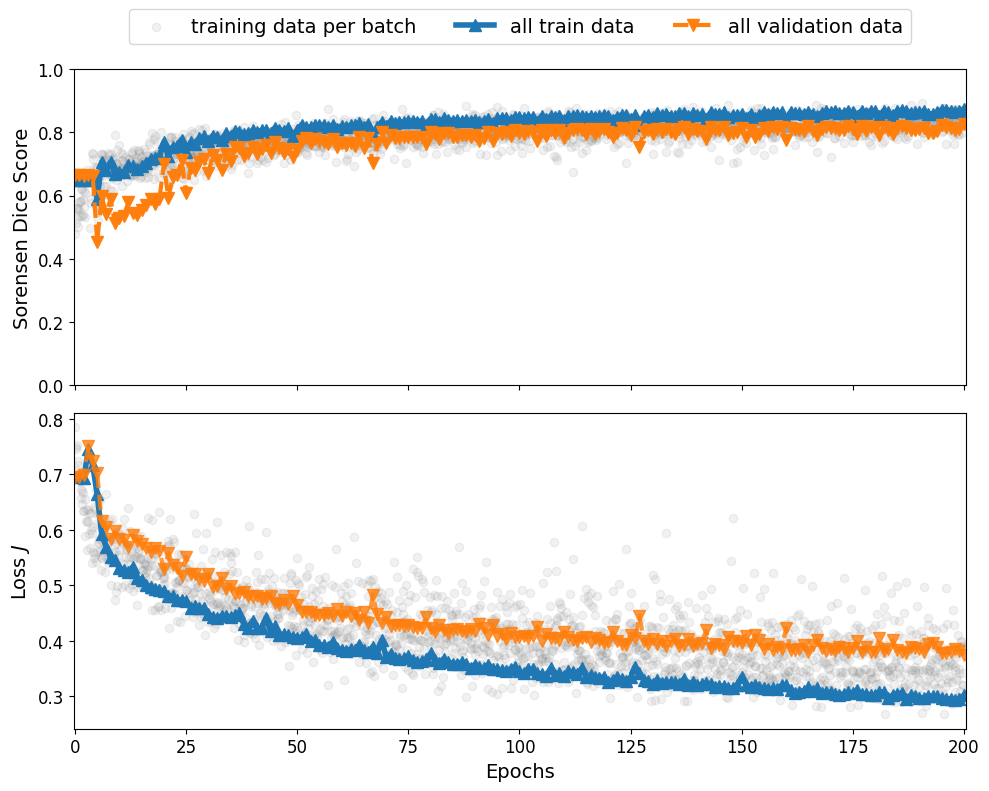

In [80]:
fig, axs, axins = mpf.plot_acc_loss_ww(mynn.log2pandas(), len(mynn.dataloader_train), test_data_label='all validation data')

We check now the final performance on the test data partition and obtan a DSC of 0.800, which is the best we have obtained thus far.

In [81]:
y_pred = []
y_true = []

for X, y, index in dataloader_test_ww:
    y_pred.append(mynn.predict_logits(X))
    y_true.append(y)
y_pred = torch.cat(y_pred).cpu()
y_true = torch.cat(y_true).cpu()

compute_dsc = SorensenDiceCriterion()
dsc = compute_dsc(y_pred, y_true)
np.array(dsc).mean()

0.79993874

### Augmenting the data

As a last attempt to improve performance we consider data augmentation. This should make the model generalize better and also decrease the chance of overfitting, since more emphasis is put on the shapes in the data, rather than their precise alignment with respect to the image frame. Here we add random horizontal and vertical flips to the data pipeline:

In [82]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    ImgToTensor2Channels(),
])

training_data = dh.WarwickDataset('WARWICK/Train', transform=transform,
                                  target_transform=TargetTransformCrossEntropy())

test_data = dh.WarwickDataset('WARWICK/Test', transform=ImgToTensor2Channels(),
                              target_transform=TargetTransformCrossEntropy())

dataloader_train_ww_augmented = DataLoader(training_data, batch_size=batch_size_train_ww, shuffle=True)
dataloader_test_ww_augmented = DataLoader(test_data, batch_size=batch_size_test_ww, shuffle=True)


The training is then similar to before:

In [83]:
fname = 'ex21_convnn_warwick_dropout%.2f_batchnorm_tuned_augmented_%iepochs_lr%.4f_bs%i.pkl'% (p_dropout_ww_tuned, nepochs_ww_tuned, lr_adam_ww_tuned, batch_size_train_ww)
try:
    mynn = mnn.load_nn(fname)
except FileNotFoundError:
    model = NeuralNetworkWarwickDropoutBatchNorm(p_dropout_ww_tuned)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww_tuned)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train_ww_augmented, dataloader_test_ww_augmented, 
                               device=device, criterion=SorensenDiceCriterion(),
                               logits2prob=LogitsToProbabilitiesImageSegmentation())
    mynn.train(nepochs=nepochs_ww_tuned)
    mynn.to_disk(fname)

The Figure below shows the performance of the model as a function of the epoch. We see that the model struggles to learn anything, since DSC and loss do not improve significantly over 100 epochs. We have experimented also with other values for the hyperparameters, but never managed to train anything useful. We believe therefore, that we would most likely need to modify the architecture of our model.

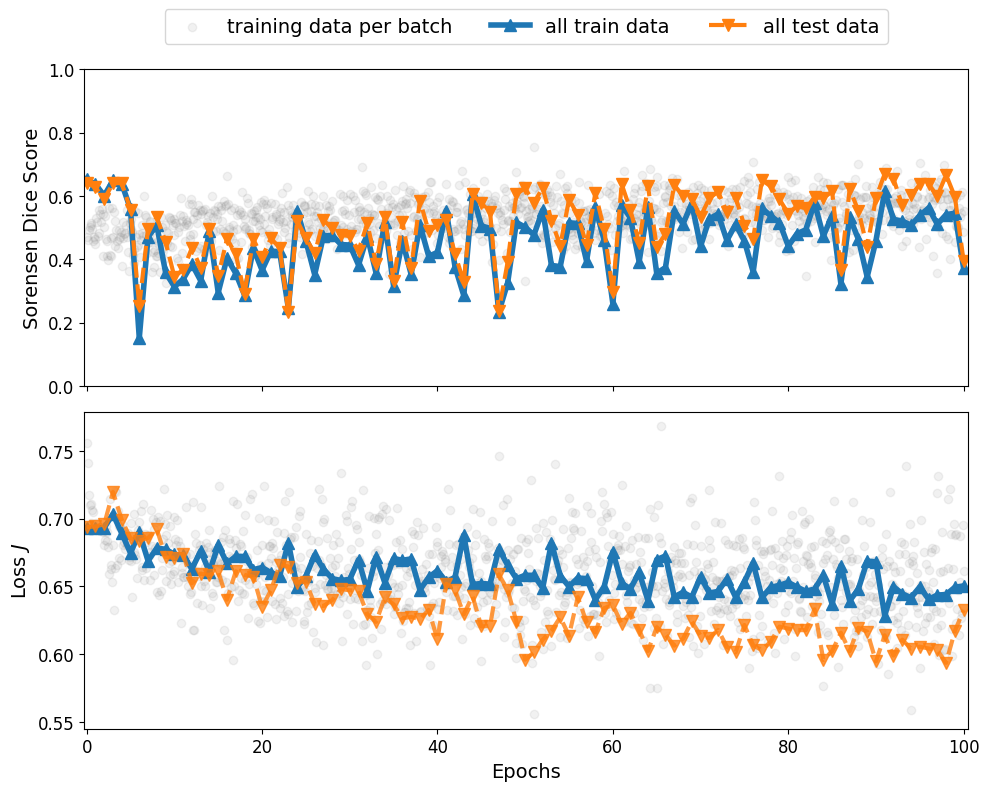

In [84]:
fig, axs, axins = mpf.plot_acc_loss_ww(mynn.log2pandas(), len(mynn.dataloader_train))

# Appendix

In this appendix we include all our codefiles necessary to run this notebook.

## Data handling

The file `data_handling.py` contains some convenience functions around handling the datasets with which we work.

In [85]:
Code(filename='data_handling.py', language='python')

#!/usr/bin/env python3

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets.vision import VisionDataset
from torchvision.transforms import ToTensor
from PIL import Image
import glob
import pickle
import numpy as np


class MNISTDataset(datasets.MNIST):
    
    def __getitem__(self, index):
        
        img, target = super(MNISTDataset, self).__getitem__(index)
        
        return img, target, index


def init_MNIST(batch_size_train, batch_size_test, shuffle=False):
    
    # Download training data from open datasets.
    training_data = MNISTDataset(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )
    print(training_data)
    
    # Download test data from open datasets.
    test_data = MNISTDataset(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )
    print(test_data)
    
    # Create data loaders
    dataloader_train = DataLoader(training_data, batch_size=batch_size_train, shuffle=shuffle)
    dataloader_test = DataLoader(test_data, batch_size=batch_size_test, shuffle=shuffle)

    for X, y, index in dataloader_train:
        print("Shape of X for train data [N, C, H, W]: ", X.shape)
        print("Shape of y for train data: ", y.shape, y.dtype)
        break
    
    for X, y, index in dataloader_test:
        print("Shape of X for test data [N, C, H, W]: ", X.shape)
        print("Shape of y for test data: ", y.shape, y.dtype)
        break

    return dataloader_train, dataloader_test

    
class WarwickDataset(VisionDataset):
    """WARWICK dataset."""

    def __init__(self, root_dir, transform=ToTensor(), target_transform=ToTensor()):
        """
        Args:
            root_dir (string): Directory with all the images and labelmasks
        """
        self.transform = transform
        self.target_transform = target_transform
        self.data, self.targets = self.from_dir(root_dir)
   

    def get_stats_data(self):
        tmp = np.array([np.array(x) for x in self.data], dtype=np.single)
        mean = tmp.mean(axis=(0,1,2))
        std = tmp.std(axis=(0,1,2))
        return mean, std
        
    
    def from_dir(self, root_dir):
        # Loads the WARWICK dataset from png images
         
        # create list of image objects
        images = []
        labelmasks = []    
        
        for ipath, lpath in zip(sorted(glob.glob(root_dir + "/image*.png")),\
                                sorted(glob.glob(root_dir + "/label*.png"))):
            
            image = Image.open(ipath)
            images.append(image)
            
            labelmask = Image.open(lpath)
            labelmasks.append(labelmask)
            
        return images, labelmasks


    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target, index
    
    
    def dataset2tensors(self):
        X = []
        y = []
        for td, tt in zip(self.data, self.targets):
            X.append(self.transform(td))
            y.append(self.target_transform(tt))
        return torch.stack(X), torch.stack(y)

## Neural Network Abstraction

The file `my_nn_pytorch.py` contains the class definition for our neural network abstraction layer:

In [86]:
Code(filename='my_nn_pytorch.py', language='python')

import torch
from torch import nn
import pandas as pd
import pickle
import numpy as np
from timeit import default_timer as timer



class AccuracyCriterion():
    
    def __init__(self):
        self.name = "accuracy"
        self.onehot = OneHotEncoding()

    def __call__(self, logits, target, full=False):
        return [(self.onehot(logits) == target).type(torch.float).cpu().numpy()]


class LogitsToProbabilities():
    
    def __init__(self):
        self.softmax = nn.Softmax(dim=1)
    
    def __call__(self, logits):
        return self.softmax(logits)


class OneHotEncoding():
    
    def __call__(self, y):
        return y.argmax(1)


class MyNeuralNetwork():
    """
    """
    
    def __init__(self, 
                 model, 
                 loss_fn, 
                 optimizer, 
                 dataloader_train, 
                 dataloader_test, 
                 device='cpu', 
                 criterion=AccuracyCriterion(),
                 logits2prob=LogitsToProbabilities(),
                 onehot=OneHotEncoding(),
                 custom_eval=None):
        """
        """
        
        self.model = model.to(device)
        print(self.model)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
        self.dataloader_train = dataloader_train
        self.dataloader_test = dataloader_test
        self.batch_size_train = dataloader_train.batch_size
        self.batch_size_test = dataloader_test.batch_size
        
        self.criterion = criterion
        self.logits2prob = logits2prob
        self.onehot = onehot
        self.device = device
        
        self.log = []
        
        self.epoch = 0
        self.iteration = 0
    
    
    def log2pandas(self):
        return pd.DataFrame(self.log)


    def add_log_entry(self, logtype, **additional_log_data):
        
        entry = {
                'iteration':   self.iteration,
                'epoch':       self.epoch,
                'logtype':     logtype,
                }
        
        for key, value in additional_log_data.items():
            entry[key] = value
        
        self.log.append(entry)
    
    
    
    def get_total_train_time(self):
        df = self.log2pandas()
        df = df[df.logtype == 'timer']
        return np.around(df.elapsed_time.sum(), decimals=1)
    
    
    def evaluate(self, dataloader=None, X=None, y=None):
        
        self.model.eval()
        
        if dataloader == None:
            with torch.no_grad():    
                logits = self.model(X)
                loss_mean = self.loss_fn(logits, y).item()
                crit = self.criterion(logits, y)
        else:
            loss_mean, crit, indices = 0, [], []
            size = len(dataloader.dataset)
            with torch.no_grad():    
                for X, y, index in dataloader:
                    X, y = X.to(self.device), y.to(self.device)
                    logits = self.model(X)
                    loss_mean += self.loss_fn(logits, y).item() * X.shape[0]
                    crit += self.criterion(logits, y)
                    indices += [index.numpy()]
#            print(crit)
#            print(indices)
#            print(loss_mean)
#            print(size)
            loss_mean /= size
            indices = np.argsort(np.concatenate(indices))
            crit = np.concatenate(crit)
            crit=crit[indices]
        
        crit_mean = crit.mean()
        return loss_mean, crit_mean, crit
    
   
    def evaluate_and_log_perf_traindata(self):
        loss_mean, crit_mean, crit = self.evaluate(self.dataloader_train)
        self.add_log_entry('performance', criterion=crit, criterion_mean=crit_mean,
                           loss=loss_mean, dataset='train')
   

    def evaluate_and_log_perf_testdata(self):
        loss_mean, crit_mean, crit = self.evaluate(self.dataloader_test)
        self.add_log_entry('performance', criterion=crit, criterion_mean=crit_mean,
                           loss

## Plotting helper functions

In the file `my_plot_functions.py` we have hidden away the plotting functions.

In [87]:
Code(filename='my_plot_functions.py', language='python')

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_acc_loss_ww(log, size_epoch, test_data_label='all test data'):

    fig, axs = plt.subplots(2, figsize=(10,8), sharex=True)

    axins = [None, None]

    train_batch = log.where(log.dataset == 'train_batch').dropna(subset=('criterion_mean', 'loss'))
    train = log.where(log.dataset == 'train').dropna(subset=('criterion_mean', 'loss'))
    test = log.where(log.dataset == 'test').dropna(subset=('criterion_mean', 'loss'))

    axs[0].scatter(train_batch.iteration/size_epoch, train_batch.criterion_mean,
                   label='training data per batch', alpha=.1, color=colors[7])
    axs[0].plot(train.epoch, train.criterion_mean, '^-', label='all train data',
                alpha=1, lw=4, color=colors[0], markersize=8)
    axs[0].plot(test.epoch, test.criterion_mean, 'v--', label=test_data_label,
                alpha=1, lw=3, color=colors[1], markersize=8)
    axs[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=14)
    axs[0].set_ylim(bottom=0., top=1.)
    axs[0].set_ylabel('Sorensen Dice Score', fontsize=14)
    axs[0].tick_params(labelsize=12)


    axs[1].scatter(train_batch.iteration/size_epoch, train_batch.loss,
                   label='training data per batch', alpha=.1, color=colors[7])
    axs[1].plot(train.epoch, train.loss, '^-', label='all training data',
                alpha=1, lw=4, color=colors[0], markersize=8)
    axs[1].plot(test.epoch, test.loss, 'v--', label=test_data_label,
                alpha=.8, lw=3, color=colors[1], markersize=8)
    axs[1].set_ylabel('Loss $J$', fontsize=14)
    axs[1].tick_params(labelsize=12)
    axs[1].set_xlabel('Epochs', fontsize=14)
    axs[1].set_xlim(left=-0.3, right=test.epoch.max()+0.5)

    fig.tight_layout()
    return fig, axs, axins



def plot_acc_loss_MNIST(log, size_epoch, axins_on=True):

    fig, axs = plt.subplots(2, figsize=(10,8), sharex=True)

    axins = [None, None]

    train_batch = log.where(log.dataset == 'train_batch').dropna(subset=('criterion_mean', 'loss'))
    train = log.where(log.dataset == 'train').dropna(subset=('criterion_mean', 'loss'))
    test = log.where(log.dataset == 'test').dropna(subset=('criterion_mean', 'loss'))

    axs[0].scatter(train_batch.iteration/size_epoch, train_batch.criterion_mean*100,
                   label='training data per batch', alpha=.1, color=colors[7])
    axs[0].plot(train.epoch, train.criterion_mean*100, '^-', label='all training data',
                alpha=1, lw=4, color=colors[0], markersize=8)
    axs[0].plot(test.epoch, test.criterion_mean*100, 'v--', label='all test data',
                alpha=1, lw=3, color=colors[1], markersize=8)
    axs[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=14)
    axs[0].set_ylim(bottom=0., top=100.)
    axs[0].set_ylabel('Accuracy in %', fontsize=14)
    axs[0].tick_params(labelsize=12)


    if axins_on:
        axins[0] = axs[0].inset_axes([0.2, 0.1, 0.7, 0.3])
        axins[0].scatter(train_batch.iteration/size_epoch, train_batch.criterion_mean*100,
                         label='training data per batch', alpha=.1, color=colors[7])
        axins[0].plot(train.epoch, train.criterion_mean*100, '^-', label='all training data',
                      alpha=1, lw=4, color=colors[0], markersize=8)
        axins[0].plot(test.epoch, test.criterion_mean*100, 'v--', label='all test data',
                      alpha=1, lw=3, color=colors[1], markersize=8)
        axins[0].set_xlim(0, test.epoch.max()+0.5)
        axins[0].set_ylim(95, 100)
        axs[0].indicate_inset_zoom(axins[0], edgecolor="black")


    axs[1].scatter(train_batch.iteration/size_epoch, train_batch.loss,
                   label='training data per batch', alpha=.1, color=colors[7])
    axs[1].plot(train.epoch, train.loss, '^-', label='all training data',
                alpha=1, lw=4, color=colors[0], markersize=8)
    axs[1].plot(test.epoch, test.loss